# PSMC Demographic Reconstruction

This notebook implements demographic history reconstruction using PSMC (Pairwise Sequentially Markovian Coalescent).




In [7]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import re

# Configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

DATA_DIR = Path(config['data_dir'])
OUTPUT_DIR = Path(config['output_dir'])
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Data directory: data
Output directory: outputs


## Step 1: – FASTA ➜ PSMC input


In [8]:
from Bio import SeqIO

def fasta_to_psmc_input(fasta_file, output_file, sample_name="sample"):
    """Convert FASTA genome to the consensus format PSMC expects."""
    sequences = []
    for record in SeqIO.parse(str(fasta_file), "fasta"):
        seq = str(record.seq).upper()
        seq = re.sub(r"[^ATCG]", "N", seq)
        sequences.append((record.id, seq))

    with open(output_file, "w") as handle:
        handle.write(f">{sample_name}\n")
        for chrom_id, seq in sequences:
            for i in range(0, len(seq), 60):
                handle.write(seq[i:i+60] + "\n")

    print(f"Converted {fasta_file} to PSMC format: {output_file}")

def resolve_genome():
    genome_cfg = config.get("genome_file", "./data/Rhinopithecus_roxellana-001.fasta")
    genome_path = Path(genome_cfg)
    if not genome_path.is_absolute():
        genome_path = (Path.cwd() / genome_path).resolve()
    return genome_path

GENOME_FILE = resolve_genome()
PSMC_INPUT = OUTPUT_DIR / "psmc_input.txt"

if GENOME_FILE.exists():
    fasta_to_psmc_input(GENOME_FILE, PSMC_INPUT, sample_name="sample1")
else:
    print(f"Warning: Genome file not found at {GENOME_FILE}")
    print("Please update config['genome_file'] with a valid FASTA path.")

Converted /Users/divyadhole/Capstone-project/data/Rhinopithecus_roxellana-001.fasta to PSMC format: outputs/psmc_input.txt


## Step 2: Run PSMC analysis


In [9]:
def run_psmc(input_file, output_file, params=None):
    if params is None:
        params = config.get('psmc_params', {})

    cmd = ['psmc']
    for key, value in params.items():
        cmd.extend([key, str(value)])
    cmd.extend(['-o', str(output_file), str(input_file)])

    print(f"Running PSMC: {' '.join(cmd)}")
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"PSMC error: {result.stderr}")
        raise RuntimeError("PSMC failed")

    print(f"PSMC completed: {output_file}")
    return output_file

PSMC_OUTPUT = OUTPUT_DIR / "psmc_output.psmc"

if PSMC_INPUT.exists():
    run_psmc(PSMC_INPUT, PSMC_OUTPUT)
else:
    print("PSMC input file not found. Run Step 1 first.")

Running PSMC: psmc -N 25 -t 15 -r 5 -p 4+25*2+4+6 -o outputs/psmc_output.psmc outputs/psmc_input.txt
PSMC completed: outputs/psmc_output.psmc


## Step 3: Parse PSMC output


In [10]:
def parse_psmc_output(psmc_file, mu=2.5e-8, genome_length=1e9, generation_time=25):
    """
    Parses RS lines from the PSMC output and estimates Ne assuming:
      - mu: mutation rate per site per generation
      - genome_length: callable genome length
      - generation_time: years per generation
    """
    time_points = []
    ne_values = []

    with open(psmc_file, 'r') as f:
        for line in f:
            if line.startswith('RS'):
                parts = line.strip().split('\t')
                # Format: RS\tk\tleft_time\tlambda_k\ttheta_k
                if len(parts) >= 5:
                    time_k = float(parts[2])
                    lambda_k = float(parts[3])
                    # theta_k = parts[4] but we only need lambda here

                    if mu > 0 and genome_length > 0:
                        ne = lambda_k / (4 * mu * genome_length)
                    else:
                        ne = lambda_k

                    time_points.append(time_k)
                    ne_values.append(ne)

    df = pd.DataFrame({
        "time_generations": time_points,
        "Ne": ne_values,
        "time_years": [t * 2 * generation_time for t in time_points]
    })
    return df

if PSMC_OUTPUT.exists():
    psmc_results = parse_psmc_output(PSMC_OUTPUT)
    psmc_results.to_csv(OUTPUT_DIR / "psmc_results.csv", index=False)
    print("PSMC results parsed successfully!")
    display(psmc_results.head())
else:
    print("PSMC output file not found. Run Step 2 first.")

PSMC results parsed successfully!


,time_generations,Ne,time_years
0,0.000000,0.01,0.00000
1,0.008290,0.01,0.41450
2,0.017266,0.01,0.86330
3,0.026987,0.01,1.34935
4,0.037514,0.01,1.87570


## Step 4: Visualize demographic history


Saved plot: outputs/demographic_history.png


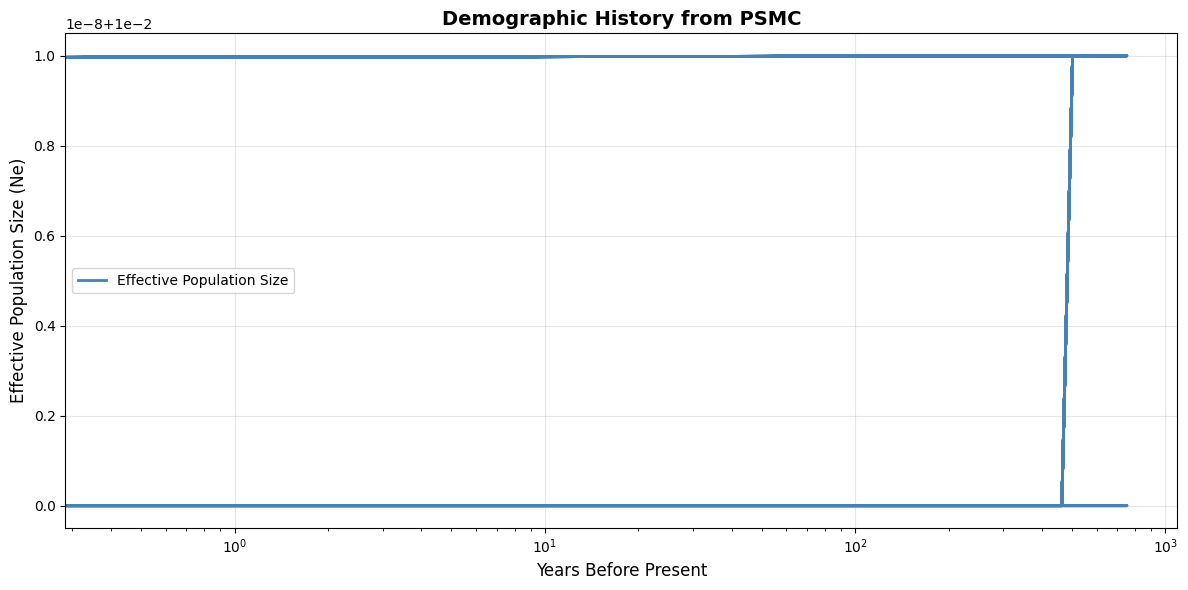


PSMC analysis complete!


In [11]:
def plot_demographic_history(psmc_df, output_file=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.semilogx(psmc_df["time_years"], psmc_df["Ne"],
                linewidth=2, color="steelblue",
                label="Effective Population Size")

    ax.set_xlabel("Years Before Present", fontsize=12)
    ax.set_ylabel("Effective Population Size (Ne)", fontsize=12)
    ax.set_title("Demographic History from PSMC", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved plot: {output_file}")
    plt.show()
    return fig

results_path = OUTPUT_DIR / "psmc_results.csv"
if results_path.exists():
    psmc_df = pd.read_csv(results_path)
    plot_demographic_history(psmc_df, OUTPUT_DIR / "demographic_history.png")
    print("\nPSMC analysis complete!")
else:
    print("PSMC results not found. Run previous steps first.")

Saved plot: outputs/demographic_history.png


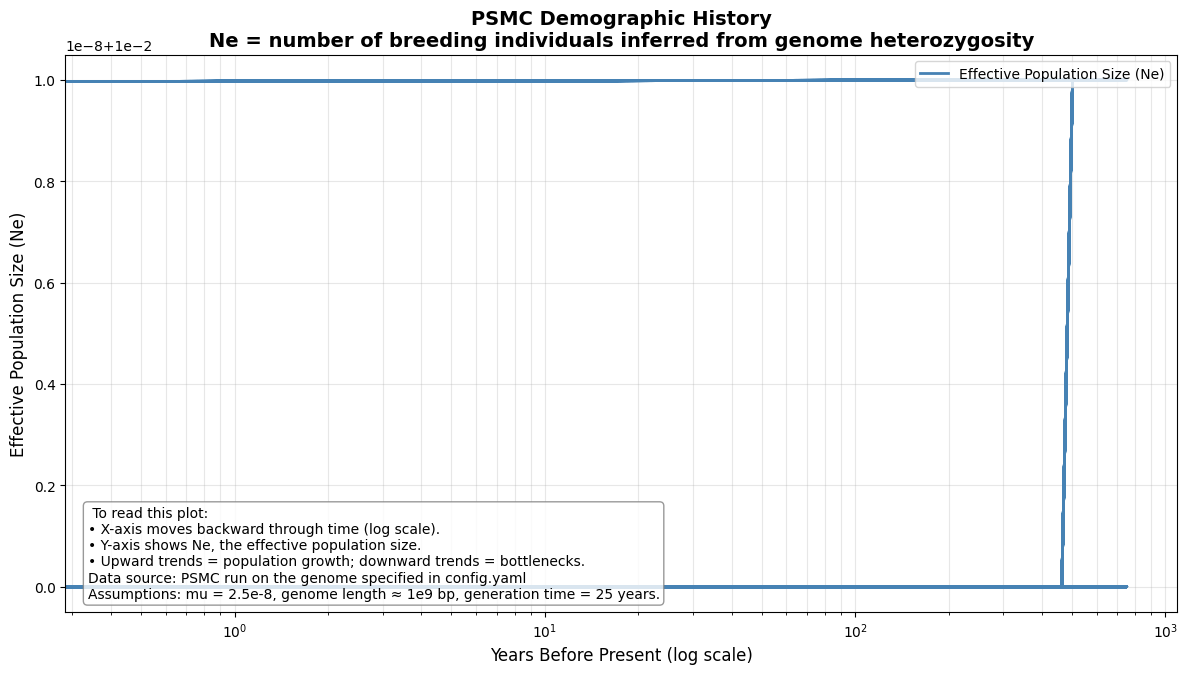


PSMC analysis complete!


In [12]:
def plot_demographic_history(psmc_df, output_file=None):
    """
    Create a demographic history plot with descriptive annotations so non-experts
    can interpret PSMC results.
    """
    if psmc_df is None or psmc_df.empty:
        print("No PSMC results available to plot.")
        return None

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.semilogx(
        psmc_df["time_years"],
        psmc_df["Ne"],
        linewidth=2,
        color="steelblue",
        label="Effective Population Size (Ne)",
    )

    ax.set_xlabel("Years Before Present (log scale)", fontsize=12)
    ax.set_ylabel("Effective Population Size (Ne)", fontsize=12)
    ax.set_title(
        "PSMC Demographic History\nNe = number of breeding individuals inferred from genome heterozygosity",
        fontsize=14,
        fontweight="bold",
    )
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(loc="upper right")

    annotation_text = (
        " To read this plot:\n"
        "• X-axis moves backward through time (log scale).\n"
        "• Y-axis shows Ne, the effective population size.\n"
        "• Upward trends = population growth; downward trends = bottlenecks.\n"
        "Data source: PSMC run on the genome specified in config.yaml\n"
        "Assumptions: mu = 2.5e-8, genome length ≈ 1e9 bp, generation time = 25 years."
    )
    ax.text(
        0.02,
        0.02,
        annotation_text,
        transform=ax.transAxes,
        fontsize=10,
        va="bottom",
        ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8, edgecolor="gray"),
    )

    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved plot: {output_file}")

    plt.show()
    return fig


results_path = OUTPUT_DIR / "psmc_results.csv"
if results_path.exists():
    psmc_df = pd.read_csv(results_path)
    plot_demographic_history(psmc_df, OUTPUT_DIR / "demographic_history.png")
    print("\nPSMC analysis complete!")
else:
    print("PSMC results not found. Run previous steps first.")

### What does this PSMC analysis tell us?

- **What is PSMC?** The Pairwise Sequentially Markovian Coalescent infers historical effective population size (Ne) from genome-wide heterozygosity in a single diploid individual. It models how the two haplotypes coalesce through time, converting that into estimates of population size.
- **Why run it here?** By converting the reference genome (`Rhinopithecus_roxellana-001.fasta`) into PSMC input, running `psmc` with the parameters in `config.yaml`, and parsing the RS intervals, we reconstruct how Ne changed from recent times back into the Pleistocene.
- **What do we get?** The `psmc_results.csv` table lists, for each time slice, the time before present (years/generations) and the corresponding Ne estimate. The saved figure `outputs/demographic_history.png` plots this trajectory on a log time axis.
- **How to interpret the plot?**
  - The X-axis moves backward in time (older periods on the right).
  - The Y-axis shows Ne (effective breeders). Upward segments suggest expansion; downward segments indicate bottlenecks.
  - Annotations describe the mutation rate (2.5e-8), assumed genome length (~1e9 bp), and generation time (25 years). Adjusting these parameters rescales the curve but not its overall shape.
- **Communicating to others:** “Using PSMC on the rhinopithecus reference genome, we inferred long-term population history from genomic heterozygosity. The resulting curve highlights when effective population size grew or contracted, providing context for demographic events that may align with climatic or ecological shifts.”